In [24]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.utils import resample
import math as math

In [2]:
Data = pd.read_csv('House_Price_Regression.csv')

Data = Data.loc[:, ['latitude', 'longitude', 'price', 'size_in_m_2']]

Data.head()

,latitude,longitude,price,size_in_m_2
0,25.113208,55.138932,2700000,100.242337
1,25.106809,55.151201,2850000,146.972546
2,25.063302,55.137728,1150000,181.253753
3,25.227295,55.341761,2850000,187.664060
4,25.114275,55.139764,1729200,47.101821


## Distancias

In [3]:
def Dist_Euclidea(x_i, x_r):

        Dist_Euclidea = ( ( x_i - x_r )**2 ).sum()

        Dist_Euclidea = np.sqrt(Dist_Euclidea)

        return Dist_Euclidea

In [4]:
def Matrix_Dist_Euclidea(Data):

    # Paso previo necesario si Data es pd.DataFrame  -->  Data = Data.to_numpy()

    n = len(Data)

    M =  np.empty((n , n))

    
    for i in range(0, n):

         for r in range(0, n):

             if i >= r :
               
                 M[i,r] = 0

             else :

                 M[i,r] = Dist_Euclidea(Data[i,:] , Data[r,:])   

                      
    return M 

In [5]:
def Dist_Minkowski(x_i, x_r, q):

    Dist_Minkowski = ( ( ( abs( x_i - x_r) )**q ).sum() )**(1/q)

    return Dist_Minkowski

In [6]:
def Matrix_Dist_Minkowski(Data, q):

    # Paso previo necesario si Data es pd.DataFrame  -->  Data = Data.to_numpy()

    n = len(Data)

    M =  np.empty((n , n))

    
    for i in range(0, n):

         for r in range(0, n):

             if i >= r :
               
                 M[i,r] = 0

             else :

                 M[i,r] = Dist_Minkowski(Data[i,:] , Data[r,:], q)   

                      
    return M 

In [7]:
def Dist_Canberra(x_i, x_r):

    numerator =  abs( x_i - x_r )

    denominator =  ( abs(x_i) + abs(x_r) )
       
    numerator=np.array([numerator], dtype=float)

    denominator=np.array([denominator], dtype=float)

    # The following code is to eliminate zero division problems

    Dist_Canberra = ( np.divide( numerator , denominator , out=np.zeros_like(numerator), where=denominator!=0) ).sum() 

    return Dist_Canberra

In [8]:
def Matrix_Dist_Canberra(Data):

    # Paso previo necesario si Data es pd.DataFrame  -->  Data = Data.to_numpy()

    n = len(Data)

    M =  np.empty((n , n))

    
    for i in range(0, n):

         for r in range(0, n):

             if i >= r :
               
                 M[i,r] = 0

             else :

                 M[i,r] = Dist_Canberra(Data[i,:] , Data[r,:])   

                      
    return M 

In [11]:
def Dist_Mahalanobis_2(x_i, x_r, S_inv):  # Más eficiente que la anterior

    # All the columns of Data must be type = 'float' or 'int' (specially not 'object'), in other case we will find 
    # dimensional problems when Python compute   x @ S_inv @ x.T

    x = (x_i - x_r)

    x = np.array([x]) # necessary step to transpose a 1D array

    Dist_Maha = np.sqrt( x @ S_inv @ x.T )  # x @ S_inv @ x.T = np.matmul( np.matmul(x , S_inv) , x.T )

    Dist_Maha = float(Dist_Maha)

    return Dist_Maha

In [12]:
def Dist_Mahalanobis_3(x, S_inv):  # Más eficiente que la anterior

    # All the columns of Data must be type = 'float' or 'int' (specially not 'object'), in other case we will find 
    # dimensional problems when Python compute   x @ S_inv @ x.T

    # x = (x_i - x_r)

    # x = np.array([x]) # necessary step to transpose a 1D array

    Dist_Maha = np.sqrt( x @ S_inv @ x.T )  # x @ S_inv @ x.T = np.matmul( np.matmul(x , S_inv) , x.T )

    Dist_Maha = float(Dist_Maha)

    return Dist_Maha

In [13]:
def Matrix_Dist_Mahalanobis_3(Data):

    # Paso previo necesario si Data es pd.DataFrame  -->  Data = Data.to_numpy()

    n = len(Data)

    M =  np.empty((n , n))

    S_inv=np.linalg.inv( np.cov(Data , rowvar=False) )

   
    for i in range(0, n):

         for r in range(0, n):

             if i >= r :
               
                 M[i,r] = 0

             else :

                 M[i,r] = Dist_Mahalanobis_3(x = np.array([Data[i,:] - Data[r,:]]) , S_inv=S_inv ) 

                      
    return M 

## Algoritmo k-medias

In [55]:
def k_means(Data, Distance_function, q, S_inv, Distance_Matrix, random_seed, k, max_n_iter):

    # Data --> a numpy array
    # Distance_function --> a distance function betwwen arrays
    # Distance_Matriz --> a distance matrix (en forma completa)
    # random_seed --> semilla aleatoria
    # k --> nº clusters
    # max_n_iter --> nº maximo de iteraciones del algoritmo

###########################################################################################

    lista_df_clusters_finales_iter = []

###########################################################################################

# Se generan los clusters iniciales aleatoreamente


    sample = resample(range(0, len(Data)), n_samples=len(Data), replace=False, random_state=random_seed)

    df_sample = pd.DataFrame({'index': range(0,len(Data)) , 'sample':sample})

    Q = []

    for q in np.arange(0 , 1 + 1/k , 1/k):

        Q.append( np.quantile( range(0, len(Data)) , q ).round(0) )



    labels_clusters = np.array([0])

    for j in range(0,k):
   
        labels_clusters = np.concatenate([labels_clusters, np.repeat( j, len( df_sample.loc[Q[j]:(math.floor(Q[j+1])-1), 'sample'] ) ) ] ) 
 

    df_cluster = pd.DataFrame({'observacion': df_sample['sample'] , 'cluster': labels_clusters})

    lista_df_clusters_finales_iter.append(df_cluster)

###########################################################################################

# calculamos los centroides de los clusters iniciales

    M = Distance_Matrix

   ######################

    centroides = []

    for j in range(0, k):

      observations_cluster_j = df_cluster.loc[df_cluster.cluster == j ,].observacion

      Data_cluster_j = Data[observations_cluster_j , :]

      Centroide_cluster_j =  Data_cluster_j.mean(axis=0)

      centroides.append( Centroide_cluster_j  ) 
###########################################################################################


   # Calculamos la suma de varianzas intra cluster para los clusters iniciales

    lista_suma_varianzas_intra_cluster = []

    distancias, varianzas_intra_cluster , suma_varianzas_intra_cluster = [], [], []

    for j in range(0,k):

        for i in df_cluster.loc[df_cluster.cluster == j, 'observacion']:

            if Distance_function == Dist_Euclidea: distancias.append( Distance_function( Data[i,:] , centroides[j] ) )

            if Distance_function == Dist_Minkowski: distancias.append( Distance_function( Data[i,:] , centroides[j] , q ) )

            if Distance_function == Dist_Canberra: distancias.append( Distance_function( Data[i,:] , centroides[j] ) )

            if Distance_function == Dist_Mahalanobis_2: distancias.append( Distance_function( Data[i,:] , centroides[j] , S_inv) )
            

        varianzas_intra_cluster.append( sum(distancias) )


    suma_varianzas_intra_cluster.append( sum(varianzas_intra_cluster) )

    lista_suma_varianzas_intra_cluster.append( suma_varianzas_intra_cluster )


###########################################################################################


# Asignar cada observacion a su cluster más cercano 


    for b in range(0 , max_n_iter):
       

       # Calculamos los nuevos clusters 

        labels_clusters = []

        for i in df_sample['sample']:

            distancias = []
    
            for j in range(0,k):

                if Distance_function == Dist_Euclidea: distancias.append( Distance_function( Data[i,:] , centroides[j] ) )

                if Distance_function == Dist_Minkowski: distancias.append( Distance_function( Data[i,:] , centroides[j] , q ) )
            
                if Distance_function == Dist_Canberra: distancias.append( Distance_function( Data[i,:] , centroides[j] ) )

                if Distance_function == Dist_Mahalanobis_2: distancias.append( Distance_function( Data[i,:] , centroides[j] , S_inv) )
                            

            df_distancias = pd.DataFrame({'Distancias' : distancias , 'Cluster': range(0,k)})

            df_distancias_sort = df_distancias.sort_values(by='Distancias', ascending=True)

            labels_clusters.append( df_distancias_sort.iloc[0]['Cluster'] )

        
        
        df_cluster = pd.DataFrame({'observacion' : df_sample['sample'] , 'cluster': labels_clusters})

###########################################################################################


       # Calculamos los centroides de los nuevos clusters

        centroides = []
        label_medoids =[]


        for j in range(0, k):                    
                
            observations_cluster_j = df_cluster.loc[df_cluster.cluster == j ,].observacion

            Data_cluster_j = Data[observations_cluster_j , :]

            Centroide_cluster_j = Data_cluster_j.mean(axis=0)

            centroides.append( Centroide_cluster_j  ) # su componente j es el centroide del cluster j


###########################################################################################

        # Calculamos la suma de varianzas intra cluster para los nuevos clusters

        distancias, varianzas_intra_cluster , suma_varianzas_intra_cluster = [], [], []

        for j in range(0,k):

            for i in df_cluster.loc[df_cluster.cluster == j, 'observacion']:

                if Distance_function == Dist_Euclidea: distancias.append( Distance_function( Data[i,:] , centroides[j] ) )

                if Distance_function == Dist_Minkowski: distancias.append( Distance_function( Data[i,:] , centroides[j] , q ) )

                if Distance_function == Dist_Canberra: distancias.append( Distance_function( Data[i,:] , centroides[j] ) )

                if Distance_function == Dist_Mahalanobis_2: distancias.append( Distance_function( Data[i,:] , centroides[j] , S_inv) )
            

            varianzas_intra_cluster.append( sum(distancias) )


        suma_varianzas_intra_cluster.append( sum(varianzas_intra_cluster) )

        lista_suma_varianzas_intra_cluster.append( suma_varianzas_intra_cluster )


######################################################################################

        df_clusters_finales_iter = pd.DataFrame({'observaciones': df_sample['sample']  , 'cluster': labels_clusters })

        lista_df_clusters_finales_iter.append(df_clusters_finales_iter)

######################################################################################
######################################################################################
    
    from itertools import chain

    # unlist a list:

    lista_suma_varianzas_intra_cluster = list(chain.from_iterable(lista_suma_varianzas_intra_cluster))

    df_suma_varianzas_intra_cluster = pd.DataFrame({'sum_var_intra_cluster':lista_suma_varianzas_intra_cluster  , 'iter': range(0, max_n_iter+1)})
    
    sort_df_suma_varianzas_intra_cluster = df_suma_varianzas_intra_cluster.sort_values(by='sum_var_intra_cluster', ascending=True)
    

######################################################################################

    return lista_df_clusters_finales_iter , sort_df_suma_varianzas_intra_cluster,  df_suma_varianzas_intra_cluster


### Prueba con la distancia Euclidea

In [32]:
Data_numpy = Data.to_numpy()

In [33]:
Distance_Matrix = Matrix_Dist_Euclidea(Data_numpy)

In [34]:
Distance_Matrix = Distance_Matrix + Distance_Matrix.T

In [35]:
lista_df_clusters_finales_iter,  sort_df_suma_varianzas_intra_cluster, df_suma_varianzas_intra_cluster = k_means(Data=Data_numpy , Distance_function=Dist_Euclidea, q=1,  Distance_Matrix=Distance_Matrix, random_seed=123, k=4, max_n_iter=5)


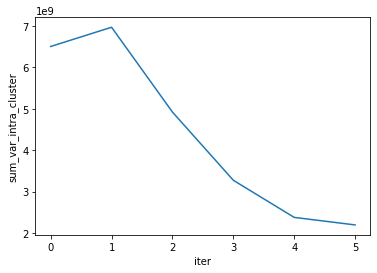

In [36]:
plot = sns.lineplot(data=df_suma_varianzas_intra_cluster, y='sum_var_intra_cluster', x='iter')

In [37]:
sort_df_suma_varianzas_intra_cluster.head(7)

,sum_var_intra_cluster,iter
5,2.193962e+09,5
4,2.375764e+09,4
3,3.272184e+09,3
2,4.918764e+09,2
0,6.502255e+09,0
1,6.966516e+09,1


In [38]:
lista_df_clusters_finales_iter[5]

,observaciones,cluster
0,382,0.0
1,732,2.0
2,1888,1.0
3,679,1.0
4,1004,3.0
...,...,...
1900,1122,1.0
1901,1346,1.0
1902,1406,1.0
1903,1389,2.0


### Prueba distancia Minkowski

In [39]:
Distance_Matrix = Matrix_Dist_Minkowski(Data_numpy , q=1)

In [40]:
Distance_Matrix = Distance_Matrix + Distance_Matrix.T

In [41]:
lista_df_clusters_finales_iter,  sort_df_suma_varianzas_intra_cluster, df_suma_varianzas_intra_cluster = k_means(Data=Data_numpy , Distance_function=Dist_Minkowski, q=1 , Distance_Matrix=Distance_Matrix, random_seed=123, k=4, max_n_iter=5)


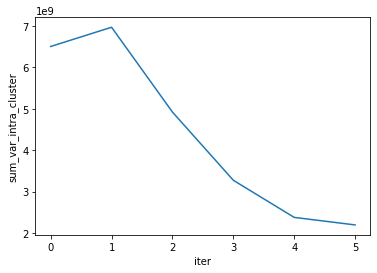

In [42]:
plot = sns.lineplot(data=df_suma_varianzas_intra_cluster, y='sum_var_intra_cluster', x='iter')

In [44]:
sort_df_suma_varianzas_intra_cluster.head(7)

,sum_var_intra_cluster,iter
5,2.194116e+09,5
4,2.375922e+09,4
3,3.272361e+09,3
2,4.918986e+09,2
0,6.502511e+09,0
1,6.966809e+09,1


In [ ]:
lista_df_clusters_finales_iter[5]

### Prueba con Distancia Canberra

In [56]:
Distance_Matrix = Matrix_Dist_Canberra(Data_numpy)

Distance_Matrix = Distance_Matrix + Distance_Matrix.T

In [57]:
lista_df_clusters_finales_iter,  sort_df_suma_varianzas_intra_cluster, df_suma_varianzas_intra_cluster = k_means(Data=Data_numpy , Distance_function=Dist_Canberra, q=1, S_inv='none', Distance_Matrix=Distance_Matrix, random_seed=123, k=4, max_n_iter=5)


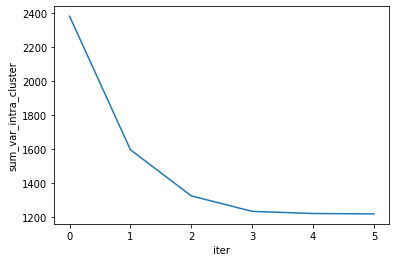

In [58]:
plot = sns.lineplot(data=df_suma_varianzas_intra_cluster, y='sum_var_intra_cluster', x='iter')

In [59]:
sort_df_suma_varianzas_intra_cluster.head(7)

,sum_var_intra_cluster,iter
5,1219.844538,5
4,1222.280240,4
3,1234.837059,3
2,1326.120915,2
1,1597.624708,1
0,2383.752934,0


In [60]:
lista_df_clusters_finales_iter[5]

,observaciones,cluster
0,382,3.0
1,732,2.0
2,1888,2.0
3,679,1.0
4,1004,0.0
...,...,...
1900,1122,1.0
1901,1346,2.0
1902,1406,1.0
1903,1389,2.0


### Prueba Distancia Mahalanobis

In [48]:
S_inv = np.linalg.inv( np.cov(Data_numpy , rowvar=False) )

In [49]:
Distance_Matrix = Matrix_Dist_Mahalanobis_3(Data_numpy)

Distance_Matrix = Distance_Matrix + Distance_Matrix.T

In [50]:
lista_df_clusters_finales_iter,  sort_df_suma_varianzas_intra_cluster, df_suma_varianzas_intra_cluster = k_means(Data=Data_numpy , Distance_function=Dist_Mahalanobis_2, q=1, S_inv=S_inv, Distance_Matrix=Distance_Matrix, random_seed=123, k=4, max_n_iter=5)


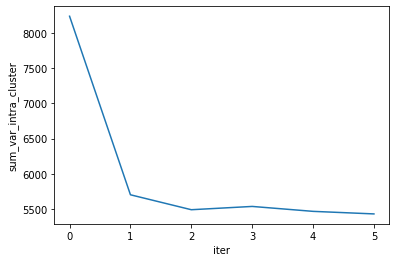

In [51]:
plot = sns.lineplot(data=df_suma_varianzas_intra_cluster, y='sum_var_intra_cluster', x='iter')

In [52]:
sort_df_suma_varianzas_intra_cluster.head(7)

,sum_var_intra_cluster,iter
5,5434.201812,5
4,5470.426367,4
2,5493.547838,2
3,5540.167518,3
1,5705.047864,1
0,8232.426619,0


In [53]:
lista_df_clusters_finales_iter[5]

,observaciones,cluster
0,382,3.0
1,732,2.0
2,1888,3.0
3,679,2.0
4,1004,1.0
...,...,...
1900,1122,2.0
1901,1346,1.0
1902,1406,2.0
1903,1389,0.0
